# US IPO CLASSYFICATION 2022

**Table of contents**

Abstract

About dataset

Prerequisites

Data exploration

Feature engineering & Model training

Summmary


## Abstract


The subject of the project is to create binary classyficator for US IPO. Based on dataset from Bloomberg platform we will try to implement model, which will tell us if the price during go live date `Trade day (US)` is posivite - means if (`Open`) price is higher than estimated price(`Priced`).In this case value for classyficator will be `1` - otherwise it will be `0`.

## About dataset - US IPO
The data was taken from the **Bloomberg platform** and includes information about the US IPO from 2016 to 2022.
We can find there information such as: when the entry of a given company was announced, the name and abbreviation of the company, the date of entry of the company on the stock exchange, the price range for the purchase of shares before entering the stock exchange, the number of shares, type of offer, the main investing bank and the price after opening the first day of the stock market and some other details to be discussed later.

This dataset is just small portion of all indicators, which helps potencial investors to decide if investment in particular ICO is worth it or not.

## Prerequisites

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn import  metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data exploration

In [3]:
data = pd.read_excel("Dane/2022 US IPO data.xlsx")

In [4]:
data.head()

,Action Id,Pricing Date,Issuer Ticker,Announced Date,Filing Date,Trade Date (US),Settlement Date,Issuer Name,Filing Term Price Min,Filing Term Price Max,...,VC Backed,PE Backed,Primary Share Offering,Security Type,Filing Term Amount (M),Left Lead Bookrunner,Priced,Open,Last,VIX index
0,225870575,03/16/2021,RCPIU US,03/16/2021,11/15/2021,NaT,NaN,Reverence Acquisition Corp,10.0,10.0,...,0,0,1,Units,300.0,Goldman Sachs,10.0,#N/A Mandatory parameter [STARTDATE] cannot be...,-,NO INFO
1,225543807,12/22/2021,OACC/U US,02/12/2021,02/07/2022,NaT,NaN,Oaktree Acquisition Corp III,10.0,10.0,...,0,0,1,Units,225.0,Deutsche Bank,10.0,#N/A Mandatory parameter [STARTDATE] cannot be...,-,NO INFO
2,229154871,01/21/2022,1981926D CN,01/21/2022,05/17/2022,NaT,NaN,Agrinam Acquisition Corp,0.0,0.0,...,0,0,1,Units,120.0,BMO Capital Markets,10.0,#N/A Mandatory parameter [STARTDATE] cannot be...,-,NO INFO
3,150939120,08/24/2017,HGC AU,08/24/2017,03/05/2021,NaT,NaN,HyGIeaCare Inc,0.0,0.0,...,0,0,1,CDI (Chess Depository Interests),0.0,NaN,0.4,#N/A Mandatory parameter [STARTDATE] cannot be...,-,NO INFO
4,172120756,07/10/2018,SVRS PW,06/26/2018,01/22/2021,NaT,16.07.2018,Silvair Inc,0.0,0.0,...,0,0,1,Common,0.0,NaN,17.0,#N/A Mandatory parameter [STARTDATE] cannot be...,4.12,NO INFO


In [5]:
data.shape

(2108, 26)

At the begining let's indetify columns, which are unnecessary for our needs like:
- `Action Id` - information about id number
- `Filing Date`  - one of the date during ICO introduction - not important for our case
- `Pricing Date` - one of the date during ICO introduction - not important for our case
- `Issuer Ticker` - shortcut of the name
- `Announced Date` - date of announment of Trade Date (US)
- `Settlement Date` - one of the date during ICO introduction - not important for our case
- `Filing Term Price Min` and `Filing Term Price Max` - column `Priced` is the combination of these two
- `Filling Term Price Range` - range of filling price
- `Last` - price of ICO at 28/06/2022 

In [6]:
columns_drop = ['Action Id', 'Pricing Date', 'Filing Date', 'Filing Term Price Range', 
                'Settlement Date', 'Issuer Ticker', 'Announced Date', 
                'Filing Term Price Min', 'Filing Term Price Max', 'Last']

data.drop(columns_drop, axis=1, inplace=True)

In [7]:
data.head()

,Trade Date (US),Issuer Name,Offer Size (M),Offer Stage,SPAC,Emerging Growth Company,Secondary Share Offering,VC Backed,PE Backed,Primary Share Offering,Security Type,Filing Term Amount (M),Left Lead Bookrunner,Priced,Open,VIX index
0,NaT,Reverence Acquisition Corp,300.00000,Pending,1,1,0,0,0,1,Units,300.0,Goldman Sachs,10.0,#N/A Mandatory parameter [STARTDATE] cannot be...,NO INFO
1,NaT,Oaktree Acquisition Corp III,225.00000,Pending,1,1,0,0,0,1,Units,225.0,Deutsche Bank,10.0,#N/A Mandatory parameter [STARTDATE] cannot be...,NO INFO
2,NaT,Agrinam Acquisition Corp,120.00000,Pending,1,0,0,0,0,1,Units,120.0,BMO Capital Markets,10.0,#N/A Mandatory parameter [STARTDATE] cannot be...,NO INFO
3,NaT,HyGIeaCare Inc,7.90600,Pending,0,0,0,0,0,1,CDI (Chess Depository Interests),0.0,NaN,0.4,#N/A Mandatory parameter [STARTDATE] cannot be...,NO INFO
4,NaT,Silvair Inc,5.42186,Pending,0,0,0,0,0,1,Common,0.0,NaN,17.0,#N/A Mandatory parameter [STARTDATE] cannot be...,NO INFO


Now let's explain remain columns & their purpose:
- `Trade Date (US)` - date of introduction of ICO 
- `Issuer Name` - name of ICO
- `Offer Size (M)` - value of all stocks - if we divide `Offer Size (M)` / `Priced` we will received amount of stock before ICO was introducted
- `Offer Stage` - stage of introduction of particular ICOs
- Columns `SPAC`, `Emerging Growth Company`, `Secondary Share Offering` , `VC Backed`, `PE Backed` , `Primary Share Offering` are containing information about type of ICO in binary system
- `Security Type` 
- `Filling Term Amount (M)`
- `Left Lead Bookrunner` - bank, who is leading ICO
- `Priced` - estimation of price before introduction
- `Open` - price during `Trade Date (US)`
- `VIX index` - a popular indicator of expected volatility on the stock exchange based on S&P 500 index options

### Missing values

In [8]:
data.isna().sum()

Trade Date (US)              74
Issuer Name                   0
Offer Size (M)                0
Offer Stage                   0
SPAC                          0
Emerging Growth Company       0
Secondary Share Offering      0
VC Backed                     0
PE Backed                     0
Primary Share Offering        0
Security Type                 0
Filing Term Amount (M)        0
Left Lead Bookrunner        836
Priced                        1
Open                          0
VIX index                     0
dtype: int64

There are three columns, which contain `NA` values. 

In column `Priced` we can remove one row.
- --
Column `Left Lead Bookrunner`contains important information, which bank was leading particular ICO. In this case `NA` means that noone of these banks was leading. Let's save this information as `0` and later on we will use `OneHotEncoder` for this column..

In [9]:
data.dropna(subset=['Priced'], inplace=True)

data["Left Lead Bookrunner"].fillna('No bank', inplace=True)

In [10]:
#lets manage empty field in Trade Date(US) later during EDA

data.isna().sum()

Trade Date (US)             74
Issuer Name                  0
Offer Size (M)               0
Offer Stage                  0
SPAC                         0
Emerging Growth Company      0
Secondary Share Offering     0
VC Backed                    0
PE Backed                    0
Primary Share Offering       0
Security Type                0
Filing Term Amount (M)       0
Left Lead Bookrunner         0
Priced                       0
Open                         0
VIX index                    0
dtype: int64

### Outliers

In [11]:
data['Offer Stage'].value_counts()

Trading    2102
Pending       5
Name: Offer Stage, dtype: int64

In this case we need only `Offer Stage` which status is *Trading*. `Pending` means that the **ICO is not yet listed**.

In [12]:
data.drop(data[data['Offer Stage'] == 'Pending'].index, inplace = True)

In [13]:
data['Offer Stage'].value_counts()

Trading    2102
Name: Offer Stage, dtype: int64

After implementation of the filter column `Offer Stage` is not necessary anymore.

In [14]:
to_drop = ['Offer Stage']
data.drop(to_drop, axis=1, inplace=True)

- --

In [15]:
print(data['Open'].value_counts().sum())
data['Open'].value_counts()

2102


10                                                      188
#N/A Mandatory parameter [STARTDATE] cannot be empty     69
10.05                                                    61
10.1                                                     46
20                                                       43
                                                       ... 
29.6                                                      1
19.6                                                      1
45                                                        1
28.76                                                     1
50.1                                                      1
Name: Open, Length: 635, dtype: int64

Also in column `Open` we identify values as **#N/A Mandatory parameter [STARTDATE] cannot be empty** & **-**, which means that there is missing argumentt to fill this information on Blommerg platform

In [16]:
data.drop(data[data['Open'] == '#N/A Mandatory parameter [STARTDATE] cannot be empty'].index, inplace = True)
data.drop(data[data['Open'] == '-'].index, inplace = True)

In [17]:
print(data['Open'].value_counts().sum())
data['Open'].value_counts()

1997


10.00    188
10.05     61
10.10     46
20.00     43
10.01     35
        ... 
29.60      1
19.60      1
45.00      1
28.76      1
50.10      1
Name: Open, Length: 633, dtype: int64

In [18]:
#all NA values removed
data.isna().sum()

Trade Date (US)             0
Issuer Name                 0
Offer Size (M)              0
SPAC                        0
Emerging Growth Company     0
Secondary Share Offering    0
VC Backed                   0
PE Backed                   0
Primary Share Offering      0
Security Type               0
Filing Term Amount (M)      0
Left Lead Bookrunner        0
Priced                      0
Open                        0
VIX index                   0
dtype: int64

- --

In [19]:
data['Left Lead Bookrunner'].value_counts(ascending=True)

Dawson James Securities                         1
Paulson Investment Co Inc                       1
ThinkEquity LLC                                 1
Craig-Hallum Capital Group Ltd                  1
Spartan Capital Securities LLC                  1
Oak Ridge Financial Services Group Inc/The      1
Guggenheim Capital                              1
National Securities Corp                        1
HCFP/Capital Markets LLC                        1
Prime Number Capital LLC                        1
MDB Capital Group LLC                           1
NatWest Markets                                 2
Tiger Brokers NZ Ltd                            2
Lifesci Capital LLC                             2
FIG Partners LLC                                2
Canaccord Genuity                               2
Robert W Baird & Co                             2
EF Hutton                                       2
DA Davidson & Co                                2
Northland Securities Group LLC                  2


In the column `Left Lead Bookrunner` for the analisys purpose we should filter only posistions with 10+ values - otherwise remove row.

In [20]:
data = data.groupby('Left Lead Bookrunner').filter(lambda x: len(x) > 10)

In [21]:
data['Left Lead Bookrunner'].value_counts(ascending=False)

No bank                       745
Goldman Sachs                 202
Morgan Stanley                165
JP Morgan                     150
Citi                          118
BofA Securities               113
Credit Suisse                  72
Jefferies                      59
Deutsche Bank                  45
UBS                            40
Barclays                       39
Cowen & Co                     31
Stifel                         27
Wells Fargo                    17
Cantor Fitzgerald              12
Raymond James & Associates     12
Roth Capital Partners Inc      12
Name: Left Lead Bookrunner, dtype: int64

### Data types

In [22]:
data.dtypes

Trade Date (US)             datetime64[ns]
Issuer Name                         object
Offer Size (M)                     float64
SPAC                                 int64
Emerging Growth Company              int64
Secondary Share Offering             int64
VC Backed                            int64
PE Backed                            int64
Primary Share Offering               int64
Security Type                       object
Filing Term Amount (M)             float64
Left Lead Bookrunner                object
Priced                             float64
Open                                object
VIX index                           object
dtype: object

Let's change the data types in column correctly.
First let's focus on columns: 
- `SPAC`   
- `Emerging Growth Company`             
- `Secondary Share Offering`             
- `VC Backed`                            
- `PE Backed`                            
- `Primary Share Offering`

which should be **binary**.

In [23]:
binary_column = ['SPAC', 'Emerging Growth Company', 'Secondary Share Offering', 'VC Backed',
                'PE Backed', 'Primary Share Offering']

for col in binary_column:
    data[col] = data[col].astype('bool')

- --
Also columns `Open`& `VIX index` we should make as **float**.

In [24]:
float_column = ['Open', 'VIX index']
for col in float_column:
    data[col] = data[col].astype('float')

In [25]:
data.dtypes

Trade Date (US)             datetime64[ns]
Issuer Name                         object
Offer Size (M)                     float64
SPAC                                  bool
Emerging Growth Company               bool
Secondary Share Offering              bool
VC Backed                             bool
PE Backed                             bool
Primary Share Offering                bool
Security Type                       object
Filing Term Amount (M)             float64
Left Lead Bookrunner                object
Priced                             float64
Open                               float64
VIX index                          float64
dtype: object

In [26]:
data.sort_values(by='Trade Date (US)', inplace=True)

### Adding new columns

For the purpose of clasyfication we need to create column to indentify if the `Open` price of ICO was higher that estimated price `Priced` or lower.

****We can maintain binary classyfication - if the `Open` price was higher that `Priced` = 1 otherwise 0.****

In [27]:
data['Positive'] = data['Open'] > data['Priced']

In [28]:
data['Positive'].value_counts()

True     1239
False     620
Name: Positive, dtype: int64

After that we can remove columns `Open` & `Priced`.

In [29]:
late_drop = ['Open', 'Priced']

data.drop(late_drop, axis=1, inplace=True)

Also at this stage columns `Trade Date (US)` & `Issuer Name` we can remove.

In [30]:
last_drop = ['Trade Date (US)', 'Issuer Name']
data.drop(last_drop, axis=1, inplace=True)

In [31]:
data.head()

,Offer Size (M),SPAC,Emerging Growth Company,Secondary Share Offering,VC Backed,PE Backed,Primary Share Offering,Security Type,Filing Term Amount (M),Left Lead Bookrunner,VIX index,Positive
220,557.750,False,True,True,False,False,False,Common,485.001,Goldman Sachs,15.34,True
1314,148.005,False,True,True,False,True,True,Common,191.074,Credit Suisse,15.34,False
1934,24.000,False,True,False,False,False,True,Common,24.000,No bank,16.20,True
1708,75.000,False,True,False,True,False,True,Common,80.000,UBS,14.89,True
1269,153.180,False,True,False,True,False,True,Common,133.200,Morgan Stanley,14.89,True


## Feature Engineering & ML implementation

In [32]:
X = data.iloc[: ,: -1]  # attributes
y = data.iloc[: , -1]   # classes

Now we need prepare data for ML model. Let's create pipeline for **numeric & categorical features.**

In [35]:
# pipeline for numeric feature
numeric_features = ['Offer Size (M)', 'Filing Term Amount (M)', 'VIX index']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


# pipeline for categorical feature
categorical_features = ['Security Type', 'Left Lead Bookrunner']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# preprocessor for both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [36]:
# split dataset for train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

Let's check

### Logistic Regression

In [38]:
# search for best parameters
pipe_1 = Pipeline([('preprocessing', preprocessor),  
                   ('classifier', LogisticRegression())])

param_grid_1 = {
            'preprocessing': [preprocessor],
            'classifier__penalty':['l2'],
            'classifier__solver': ['liblinear', 'sag', 'saga'],
            'classifier__max_iter': [100, 1000]
}

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv=kfold, return_train_score=True)


grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\adria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\adria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\adria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\adria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\adria\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

{'classifier__max_iter': 100,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear',
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['Offer Size (M)', 'Filing Term Amount (M)',
                                   'VIX index']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Security Type', 'Left Lead Bookrunner'])])}

In [39]:
# implementation best params to the model
model_LR = Pipeline([('preprocessing', preprocessor),  
                     ('classifier', LogisticRegression(max_iter=100,
                                                       penalty='l2',
                                                       solver='liblinear'))])

model_LR.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [40]:
# test model on testing set
y_pred_LR = model_LR.predict(X_test)

In [41]:
# evaluate optimized model
print(classification_report(y_pred_LR, y_test))

              precision    recall  f1-score   support

       False       0.06      0.54      0.10        13
        True       0.98      0.67      0.80       359

    accuracy                           0.67       372
   macro avg       0.52      0.61      0.45       372
weighted avg       0.94      0.67      0.77       372



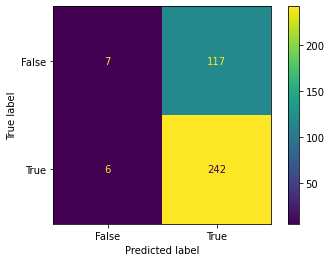

In [89]:
# confusion matrix
cm_LR = confusion_matrix(y_test, y_pred_LR)
plot_LR = ConfusionMatrixDisplay(cm_LR, display_labels=model_LR.classes_)

plot_LR.plot()

plt.show()

### SVM

In [42]:
# search for best parameters
pipe_2 = Pipeline([('preprocessing', preprocessor),  
                   ('classifier', SVC(probability=True))])

param_grid_2 = {
            'preprocessing': [preprocessor],
            'classifier__kernel':['rbf','poly','sigmoid'],
            'classifier__C': [10, 100, 1000]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 1000,
 'classifier__kernel': 'rbf',
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['Offer Size (M)', 'Filing Term Amount (M)',
                                   'VIX index']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Security Type', 'Left Lead Bookrunner'])])}

In [43]:
# implementation best params to the model
model_SVM = Pipeline([('preprocessing', preprocessor),  
                      ('classifier', SVC(C=1000,
                                         kernel='rbf',
                                         probability=True))])

model_SVM.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier', SVC(C=1000, probability=True))])

In [44]:
# evaluate optimized model
y_pred_SVM = model_SVM.predict(X_test)
print(classification_report(y_pred_SVM, y_test))

              precision    recall  f1-score   support

       False       0.48      0.58      0.53       103
        True       0.83      0.76      0.79       269

    accuracy                           0.71       372
   macro avg       0.66      0.67      0.66       372
weighted avg       0.73      0.71      0.72       372



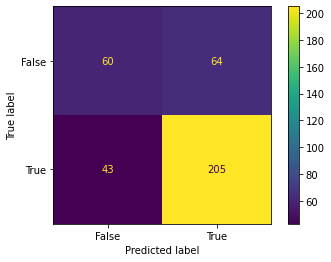

In [88]:
# confusion matrix
cm_SVM = confusion_matrix(y_test, y_pred_SVM)
plot_SVM = ConfusionMatrixDisplay(cm_SVM, display_labels=model_SVM.classes_)

plot_SVM.plot()

plt.show()

### Decision Tree Classifier

In [45]:
# search for best parameters
pipe_3 = Pipeline([('preprocessing', preprocessor),  
                   ('classifier', DecisionTreeClassifier())])

param_grid_3 = {
            'preprocessing': [preprocessor],
            'classifier__max_depth': [5,9,10,11,20,30],
            'classifier__min_samples_split': [2,3,5,10,20,30,40],
            'classifier__max_leaf_nodes': [3,4,10,14,15,16,20,30,40]
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__max_depth': 9,
 'classifier__max_leaf_nodes': 20,
 'classifier__min_samples_split': 2,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['Offer Size (M)', 'Filing Term Amount (M)',
                                   'VIX index']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Security Type', 'Left Lead Bookrunner'])])}

In [90]:
# implementation best params to the model
model_DTC = Pipeline([('preprocessing', preprocessor),  
                      ('classifier', DecisionTreeClassifier(max_depth=9,
                                                            max_leaf_nodes=20,
                                                            min_samples_split=2,))])

model_DTC.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=9, max_leaf_nodes=20))])

In [47]:
# evaluate optimized model
y_pred_DTC = model_DTC.predict(X_test)
print(classification_report(y_pred_DTC, y_test))

              precision    recall  f1-score   support

       False       0.27      0.77      0.40        44
        True       0.96      0.73      0.83       328

    accuracy                           0.73       372
   macro avg       0.62      0.75      0.62       372
weighted avg       0.88      0.73      0.78       372



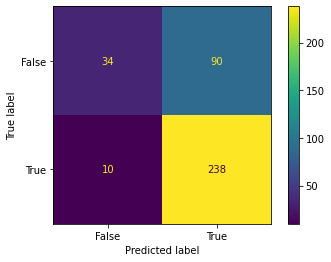

In [87]:
# confusion matrix
cm_DTC = confusion_matrix(y_test, y_pred_DTC)
plot_DTC = ConfusionMatrixDisplay(cm_DTC, display_labels=model_DTC.classes_)

plot_DTC.plot()

plt.show()

### Random Forest Classifier

In [48]:
# search for best parameters
pipe_4 = Pipeline([('preprocessing', preprocessor), 
                   ('classifier', RandomForestClassifier())])

param_grid_4 = {
                'preprocessing': [preprocessor],
                'classifier__n_estimators': [10, 50, 100],
                'classifier__max_leaf_nodes': [10, 20],
                'classifier__max_depth': [10, 20],
                'classifier__n_estimators': [200, 500, 1000],
                'classifier__max_leaf_nodes': [4, 8, 16, 32]
             }

grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 32,
 'classifier__n_estimators': 200,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['Offer Size (M)', 'Filing Term Amount (M)',
                                   'VIX index']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Security Type', 'Left Lead Bookrunner'])])}

In [49]:
# implementation best params to the model
model_RFC = Pipeline([('preprocessing', preprocessor),  
                      ('classifier', RandomForestClassifier(max_depth=10,
                                                            max_leaf_nodes=32,
                                                            n_estimators=200))])

model_RFC.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_leaf_nodes=32,
                                    

In [50]:
# evaluate optimized model
y_pred_RFC = model_RFC.predict(X_test)
print(classification_report(y_pred_RFC, y_test))

              precision    recall  f1-score   support

       False       0.11      0.64      0.19        22
        True       0.97      0.69      0.80       350

    accuracy                           0.68       372
   macro avg       0.54      0.66      0.50       372
weighted avg       0.92      0.68      0.77       372



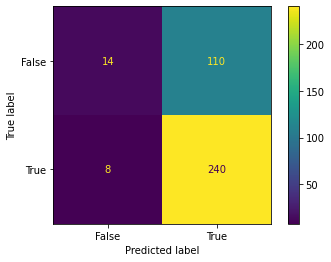

In [86]:
# confusion matrix
cm_RFC = confusion_matrix(y_test, y_pred_RFC)
plot_RFC = ConfusionMatrixDisplay(cm_RFC, display_labels=model_RFC.classes_)

plot_RFC.plot()

plt.show()

### Bagging Classifier

In [51]:
# search for best parameters
pipe_5 = Pipeline([('preprocessing', preprocessor), 
                   ('classifier', BaggingClassifier(DecisionTreeClassifier()))])

param_grid_5 = {
                'preprocessing': [preprocessor],
                'classifier__n_estimators': [10,50,100],
                'classifier__max_samples': [10,20]
             }

grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__max_samples': 20,
 'classifier__n_estimators': 50,
 'preprocessing': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', StandardScaler())]),
                                  ['Offer Size (M)', 'Filing Term Amount (M)',
                                   'VIX index']),
                                 ('cat',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Security Type', 'Left Lead Bookrunner'])])}

In [54]:
# implementation best params to the model
model_BC = Pipeline([('preprocessing', preprocessor),  
                     ('classifier', BaggingClassifier(max_samples=20,
                                                      n_estimators=50))])

model_BC.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier',
                 BaggingClassifier(max_samples=20, n_estimators=50))])

In [72]:
# evaluate optimized model
y_pred_BC = model_BC.predict(X_test)
print(classification_report(y_pred_BC, y_test))

              precision    recall  f1-score   support

       False       0.06      0.53      0.12        15
        True       0.97      0.68      0.80       357

    accuracy                           0.67       372
   macro avg       0.52      0.60      0.46       372
weighted avg       0.94      0.67      0.77       372



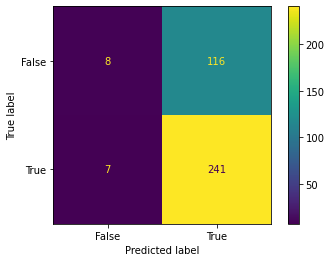

In [85]:
# confusion matrix
cm_BC = confusion_matrix(y_test, y_pred_BC)
plot_BC = ConfusionMatrixDisplay(cm_BC, display_labels=model_BC.classes_)

plot_BC.plot()

plt.show()

### Gradient Boosting Classifier

In [56]:
# search for best parameters
pipe_6 = Pipeline([('preprocessing', preprocessor), 
                   ('classifier', GradientBoostingClassifier())])


param_grid_6 = {'classifier__n_estimators': [200, 500, 1000],
              'classifier__learning_rate': [0.1, 0.2, 0.5, 0.9, 1]
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__learning_rate': 0.2, 'classifier__n_estimators': 500}

In [57]:
# implementation best params to the model
model_GBC = Pipeline([('preprocessing', preprocessor),  
                               ('classifier', GradientBoostingClassifier(learning_rate=0.2,
                                                                         n_estimators=500))])

model_GBC.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2,
                                            n_

In [58]:
# evaluate optimized model
y_pred_GBC = model_GBC.predict(X_test)
print(classification_report(y_pred_GBC, y_test))

              precision    recall  f1-score   support

       False       0.61      0.68      0.65       111
        True       0.86      0.82      0.84       261

    accuracy                           0.78       372
   macro avg       0.74      0.75      0.74       372
weighted avg       0.79      0.78      0.78       372



In [76]:
confusion_matrix(y_test, y_pred_GBC)

array([[ 76,  48],
       [ 35, 213]], dtype=int64)

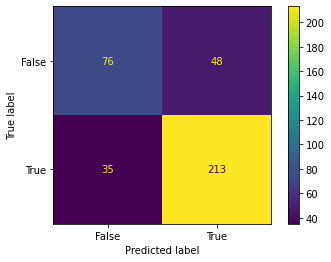

In [84]:
# confusion matrix
cm_GBC = confusion_matrix(y_test, y_pred_GBC)
plot_GBC = ConfusionMatrixDisplay(cm_GBC, display_labels=model_GBC.classes_)

plot_GBC.plot()

plt.show()

### Simply XGBClassifier

In [59]:
# search for best parameters
pipe_7 = Pipeline([('preprocessing', preprocessor), 
                   ('classifier', XGBClassifier())])


param_grid_7 = {'classifier__max_depth': [50, 100, 200],
                'classifier__learning_rate':[0.6, 0.8],
                'classifier__n_estimators': [100, 500],
            }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_

{'classifier__learning_rate': 0.6,
 'classifier__max_depth': 50,
 'classifier__n_estimators': 100}

In [60]:
# implementation best params to the model
model_XGB = Pipeline([('preprocessing', preprocessor),  
                      ('classifier', XGBClassifier(learning_rate=0.6,
                                                   max_depth=50,
                                                   n_estimators=100))])
model_XGB.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Offer Size (M)',
                                                   'Filing Term Amount (M)',
                                                   'VIX index']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Security Type',
                                                   'Left Lead Bookrunner'])])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', call...
                               gamma

In [61]:
# evaluate optimized model
y_pred_XGB = model_XGB.predict(X_test)
print(classification_report(y_pred_XGB, y_test))

              precision    recall  f1-score   support

           0       0.52      0.62      0.56       103
           1       0.84      0.78      0.81       269

    accuracy                           0.73       372
   macro avg       0.68      0.70      0.69       372
weighted avg       0.75      0.73      0.74       372



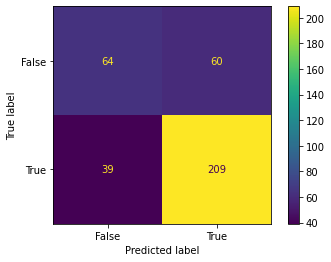

In [82]:
# confusion matrix
cm_XGB = confusion_matrix(y_test, y_pred_XGB)
plot_XGB = ConfusionMatrixDisplay(cm_XGB, display_labels=model_XGB.classes_)

plot_XGB.plot()

plt.show()

### Summary of the models

In [68]:
models = []
models.append(('LR', model_LR))
models.append(('SVM', model_SVM))
models.append(('DTC', model_DTC))
models.append(('RFC', model_RFC))
models.append(('BC', model_BC))
models.append(('GBC', model_GBC))
models.append(('XGB', model_XGB))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test , model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    if (name == 'SVM'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'SVM'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))
    else:
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

LR
precision_score: 0.6740947075208914
recall_score: 0.9758064516129032
f1_score: 0.7973640856672158
accuracy_score: 0.6693548387096774
roc_auc_score: 0.6646884755463058
SVM
precision_score: 0.7620817843866171
recall_score: 0.8266129032258065
f1_score: 0.7930367504835589
accuracy_score: 0.7123655913978495
roc_auc_score: 0.7216278616024974
DTC
precision_score: 0.725609756097561
recall_score: 0.9596774193548387
f1_score: 0.826388888888889
accuracy_score: 0.7311827956989247
roc_auc_score: 0.6568353277835587
RFC
precision_score: 0.6857142857142857
recall_score: 0.967741935483871
f1_score: 0.802675585284281
accuracy_score: 0.6827956989247311
roc_auc_score: 0.6916785900104057
BC
precision_score: 0.6750700280112045
recall_score: 0.9717741935483871
f1_score: 0.7966942148760331
accuracy_score: 0.6693548387096774
roc_auc_score: 0.6132121488033299
GBC
precision_score: 0.8160919540229885
recall_score: 0.8588709677419355
f1_score: 0.8369351669941061
accuracy_score: 0.7768817204301075
roc_auc_score:

In [95]:
metrics = {'precision_score': precision_score,
     'recall_score': recall_score,
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }

df_summary = pd.DataFrame(data=metrics)
df_summary.insert(loc=0, column='Method', value=['LR', 'SVM ', 'DTC', 'RFC', 'BC', 'GBC', 'XGB'])

df_summary.sort_values(['accuracy_score'], ascending=False)

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
5,GBC,0.816092,0.858871,0.836935,0.776882,0.812874
6,XGB,0.776952,0.842742,0.808511,0.733871,0.772259
2,DTC,0.725610,0.959677,0.826389,0.731183,0.656835
1,SVM,0.762082,0.826613,0.793037,0.712366,0.721628
3,RFC,0.685714,0.967742,0.802676,0.682796,0.691679
0,LR,0.674095,0.975806,0.797364,0.669355,0.664688
4,BC,0.675070,0.971774,0.796694,0.669355,0.613212


The best result were performed by **GBC - Gradient Boosts Classifier**. Comparing all confusion matrixs to can indytify that GBC had a lower value of FP (False Posivite) which in our case we would like to minimise. Other algotythms had problem of proper classify ICO, which were negative during introduction. Even GBC had precision result for identification of negative ICO around 0.6, which compare to others is significantly better.

## Summary

Going through to the summary we can say that performed result are not good as it supposed to be. In such project is really challenging to achieve result higher than 85% *accuracy*. People, who are working in this market are able to achieve result of proper classification of ICO around 90% - but they have to be really experience & they have to know this market extremely well. Also they evaluate particular ICO not only based on information provided by Bloomberg platform.

Other fact is that we analysis small portion of data & information which can be use for such classification. For example we did not consider such factors as:
- psychology of the people,
- general market trend - only VIX index was bringing us some information,
- some insides from particular ICO,
- news,
- general market conditions,
- even wordwide situotion,
- political situation,
- & more...

After implementation of one of above factors we should be able to increase *accuracy* ratio. Also reduction of the binary attributes can have positive impact for the models.

Finally let's look wider on analysis topic. In fact predictions on stock market are one of the most difficult thing to model - it doesn't matter how much data will be collected, how many news will be gather etc.. sometimes only one thing decides about result (for example speculation).